# HW4P2: Attention-based Speech Recognition

Welcome to the final assignment in 11785. In this HW, you will work on building a speech recognition system with attention. <br> <br>

HW Writeup: https://piazza.com/class_profile/get_resource/l37uyxe87cq5xn/lam1lcjjj0314e <br>
Kaggle competition link: https://www.kaggle.com/competitions/11-785-f22-hw4p2/ <br>
LAS Paper: https://arxiv.org/pdf/1508.01211.pdf <br>
Attention is all you need:https://arxiv.org/pdf/1706.03762.pdf

# README

## Instructions to run code: All cells need to be run! 

Ablations Strategies: 

1) Architecture considered:
LAS(
  (encoder): Listener(
    (base_lstm): LSTM(15, 512, batch_first=True, bidirectional=True)
    (pBLSTMs): Sequential(
      (0): pBLSTM(
        (blstm): LSTM(2048, 512, batch_first=True, dropout=0.3, bidirectional=True)
      )
      (1): pBLSTM(
        (blstm): LSTM(2048, 512, batch_first=True, dropout=0.3, bidirectional=True)
      )
      (2): pBLSTM(
        (blstm): LSTM(2048, 512, batch_first=True, dropout=0.3, bidirectional=True)
      )
    )
    (drop): LockedDropout()
  )
  (decoder): Speller(
    (embedding): Embedding(30, 256)
    (lstm_cells): Sequential(
      (0): LSTMCell(384, 512)
      (1): LSTMCell(512, 128)
    )
    (char_prob): Linear(in_features=128, out_features=30, bias=True)
    (attention): Attention(
      (key_projection): Linear(in_features=1024, out_features=128, bias=True)
...
      (softmax): Softmax(dim=1)
    )
  )
)


2) Epochs: 
- Trained for close to 100 epochs in total.
- 35 epochs trained without scheduler or teacher-forcing
- 15 epochs trained with teacher forcing from 1.0 reduced at 0.05 every 2 epochs
- 5 epochs trained with teacher forcing reduced at 0.025 rate every 2 epochs
- Additional 5 epochs trained with teacher forcing reduced at 0.025 rate every 2 epochs
- 15 epochs trained without teacher forcing, only scheduler


3) Hyperparameters: 
* Activation Function :RELU
* Optimizer : Adam with learning rate=1e-4 
* Loss Function : Cross Entropy Loss (Masked)
* Teacher Forcing Rate varying across the epochs, starting from 1 and reducing by 0.05 every 10 epochs
* Batch Size selected: 128

4) Regularizations Used:
* Locked Dropout in the pBLSTM layers of 0.4
* Weight Dropout in the pBLSTM layers
* Weight Tying for the character embedding layer and the character probability layer in the decoder

5) Data loading scheme:
* Time and Frequency Masking transforms were applied to improve variance of data.
* Cepstral Mean Normalization was carried out as recommended
* Toy Dataset was used to ensure model was initial working and Attention mechanism was correct.

# Initial Set-up

In [ ]:
!nvidia-smi

Wed Dec 14 06:26:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    29W /  70W |   8716MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install some required libraries
# Feel free to add more if you want
!pip install -q python-levenshtein torchsummaryX wandb

# Import

In [ ]:
import os
import pandas as pd
import numpy as np
import Levenshtein

import torch
import torchaudio

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import gc
from torchsummaryX import summary
import wandb
from glob import glob
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)

Device:  cuda


In [ ]:
# # TODO: Import drive if you are a colab user
# from google.colab import drive
# drive.mount('/content/drive')

import os.path as path 
if not path.exists("/content/drive"):
    !sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
    !sudo apt-get update -qq 2>&1 > /dev/null
    !sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
    !google-drive-ocamlfuse

    !sudo apt-get install -qq w3m # to act as web browser 
    !xdg-settings set default-web-browser w3m.desktop # to set default browser
    %cd /content
    !mkdir drive
    %cd drive
#     !mkdir MyDrive
    %cd ..
    %cd ..
    !google-drive-ocamlfuse /content/drive/MyDrive

# Config

In [ ]:
# Global config dict. Feel free to add or change if you want.
config = {
    'batch_size': 156,
    'epochs': 35,
    'lr': 1e-3
}

# Kaggle Data

In [ ]:
# TODO: Use the same Kaggle code from HW1P2, HW2P2, HW3P2
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle/

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"ripcurl11","key":"a924e45910075179ad325ad28d952008"}') # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

  Using cached kaggle-1.5.8-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8
mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [ ]:
# Download the data
!kaggle competitions download -c 11-785-f22-hw4p2
!mkdir '/content/data'

!unzip -qo '11-785-f22-hw4p2.zip' -d '/content/data'

11-785-f22-hw4p2.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘/content/data’: File exists


# Dataset Class

Transforms (Data Augmentation)

In [ ]:
import torchaudio
from torchaudio import transforms

In [ ]:
def f_mask(data):
    mask = transforms.FrequencyMasking(freq_mask_param=5)
    return mask(data)

def t_mask(data):
    mask = transforms.TimeMasking(time_mask_param=70)
    return mask(data)    

def transforms_data(data):
    data = f_mask(data)
    data = t_mask(data)
    return data

In [ ]:
# These are the various characters in the transcripts of the datasetW
VOCAB = ['<sos>',   
         'A',   'B',    'C',    'D',    
         'E',   'F',    'G',    'H',    
         'I',   'J',    'K',    'L',       
         'M',   'N',    'O',    'P',    
         'Q',   'R',    'S',    'T', 
         'U',   'V',    'W',    'X', 
         'Y',   'Z',    "'",    ' ', 
         '<eos>']

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

BATCH_SIZE = 64

In [ ]:
# TODO: Create a dataset class which is exactly the same as HW3P2. You are free to reuse it. 
# The only change is that the transcript mapping is different for this HW.
# Note: We also want to retain SOS and EOS tokens in the transcript this time.

class AudioDataset(torch.utils.data.Dataset):

    # For this homework, we give you full flexibility to design your data set class.
    # Hint: The data from HW1 is very similar to this HW

    #TODO
    def __init__(self, data_path, partition= "train", limit=-1): 
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''

        self.data_path = data_path

        self.mfcc_dir = self.data_path + 'mfcc'# TODO: MFCC directory - use partition to acces train/dev directories from kaggle data
        self.transcript_dir = self.data_path + 'transcript/raw'  # TODO: Transcripts directory - use partition to acces train/dev directories from kaggle data

        mfcc_names = sorted(os.listdir(self.mfcc_dir)) # TODO: List files in X_dir using os.listdir, optionally subset using limit to slice the number of files you load
      
        transcript_names = sorted(os.listdir(self.transcript_dir)) # TODO: List files in Y_dir using os.listdir, optionally subset using limit to slice the number of files you load
      

        assert len(mfcc_names) == len(transcript_names) # Making sure that we have the same no. of mfcc and transcripts

        self.mfccs, self.transcripts = [], []

        for i in range(0, len(mfcc_names)):
        #   Load a single mfcc
            mfcc = np.load(self.mfcc_dir+'/'+mfcc_names[i], allow_pickle=True)
            mfcc = (mfcc - np.mean(mfcc, axis=0)) / np.std(mfcc, axis=0)
            transcript = np.load(self.transcript_dir+'/'+transcript_names[i], allow_pickle=True) # Remove [SOS] and [EOS] from the transcript (Is there an efficient way to do this 
            # transcript = np.delete(transcript, [0,len(transcript)-1])
            self.mfccs.append(mfcc)
            self.transcripts.append(transcript)
        
        self.phonemes = VOCAB
        self.length = len(self.transcripts)

      

    def __len__(self):
        
        '''
        TODO: What do we return here?
        
        '''
        return self.length
        # raise NotImplemented

    def __getitem__(self, ind):
        '''
        TODO: RETURN THE MFCC COEFFICIENTS AND ITS CORRESPONDING LABELS

        If you didn't do the loading and processing of the data in __init__,
        do that here.

        Once done, return a tuple of features and labels.
        '''
        mfcc = (transforms_data(torch.FloatTensor(self.mfccs[ind]).T.unsqueeze(0)).squeeze(0).T)
        #mfcc = torch.FloatTensor(self.mfccs[ind]) # TODO
        transcripts = [self.phonemes.index(ele) for ele in self.transcripts[ind]]
        transcript = torch.LongTensor(transcripts) # TODO
        return mfcc, transcript


    def collate_fn(batch):
        '''
        TODO:
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish. 
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features, 
            and lengths of labels.
        '''
        # batch of input mfcc coefficients
        batch_mfcc_list = [xx for xx,yy in batch] # TODO
        batch_transcript_list = [yy for xx,yy in batch] # TODO

        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first)
        batch_mfcc_pad = pad_sequence(batch_mfcc_list, batch_first=True) # TODO
        lengths_mfcc =  [x.shape[0] for x in batch_mfcc_list]# TODO 

        batch_transcript_pad = pad_sequence(batch_transcript_list, batch_first=True) # TODO
        lengths_transcript = [x.shape[0] for x in batch_transcript_list] # TODO

        return batch_mfcc_pad, batch_transcript_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

       

In [ ]:
# TODO: Similarly, create a test dataset class

# Test Dataloader
#TODO
# class AudioDatasetTest(torch.utils.data.Dataset):
#    pass
class AudioDatasetTest(torch.utils.data.Dataset):

    # For this homework, we give you full flexibility to design your data set class.
    # Hint: The data from HW1 is very similar to this HW

    #TODO
    def __init__(self, data_path): 
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''
        self.data_path = data_path

        self.mfcc_dir = self.data_path + 'mfcc'# TODO: MFCC directory - use partition to acces train/dev directories from kaggle data

        mfcc_names = sorted(os.listdir(self.mfcc_dir)) # TODO: List files in X_dir using os.listdir, optionally subset using limit to slice the number of files you load
      
        self.mfccs = []

        for i in range(0, len(mfcc_names)):
        #   Load a single mfcc
            mfcc = np.load(self.mfcc_dir+'/'+mfcc_names[i], allow_pickle=True)
            mfcc = (mfcc - np.mean(mfcc, axis=0)) / np.std(mfcc, axis=0)
            self.mfccs.append(mfcc)
        
        self.phonemes = VOCAB
        
        self.length = len(self.mfccs)

        
        #TODO
        # HOW CAN WE REPRESENT PHONEMES? CAN WE CREATE A MAPPING FOR THEM?
        # HINT: TENSORS CANNOT STORE NON-NUMERICAL VALUES OR STRINGS

        #TODO
        # CREATE AN ARRAY OF ALL FEATUERS AND LABELS
        # WHAT NORMALIZATION TECHNIQUE DID YOU USE IN HW1? CAN WE USE IT HERE?
        '''
        You may decide to do this in __getitem__ if you wish.
        However, doing this here will make the __init__ function take the load of
        loading the data, and shift it away from training.
        '''
        # Do we need Label?
       

    def __len__(self):
        
        '''
        TODO: What do we return here?
        
        '''
        return self.length
        # raise NotImplemented

    def __getitem__(self, ind):
        '''
        TODO: RETURN THE MFCC COEFFICIENTS AND ITS CORRESPONDING LABELS

        If you didn't do the loading and processing of the data in __init__,
        do that here.

        Once done, return a tuple of features and labels.
        '''
        
        mfcc = torch.tensor(self.mfccs[ind]) # TODO
        return mfcc


    def collate_fn(self,batch):
        '''
        TODO:
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish. 
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features, 
            and lengths of labels.
        '''
        # batch of input mfcc coefficients
        batch_mfcc = [xx for xx in batch] # TODO

        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first)
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True) # TODO
        lengths_mfcc =  [xx.shape[0] for xx in batch_mfcc]# TODO

        # You may apply some transformation, Time and Frequency masking, here in the collate function;
        # Food for thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?
        
        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, torch.tensor(lengths_mfcc)

       

# Dataset and Dataloaders

In [ ]:
# TODO: Create the datasets and dataloaders
# All these things are similar to HW3P2
# You can reuse the same code

# The sanity check for shapes also are similar
# Please remember that the only change in the dataset for this HW is the transcripts
# So you are expected to get similar shapes like HW3P2 (Pad, pack and Oh my!)


# Create objects for the dataset class
# train_data1 = AudioDataset('./data/hw4p2/train-clean-360/') #TODO
train_data = AudioDataset('/content/data/hw4p2/train-clean-100/')
# train_data = torch.utils.data.ConcatDataset([train_data1, train_data2])
val_data = AudioDataset('/content/data/hw4p2/dev-clean/') # TODO : You can either use the same class with some modifications or make a new one :)
test_data = AudioDatasetTest('/content/data/hw4p2/test-clean/') #TODO

# Do NOT forget to pass in the collate function as parameter while creating the dataloader
train_loader = torch.utils.data.DataLoader(train_data, num_workers= 2, collate_fn=AudioDataset.collate_fn,
                                           batch_size=BATCH_SIZE, pin_memory= True,
                                           shuffle= True) #TODO
val_loader = torch.utils.data.DataLoader(val_data, num_workers= 2, collate_fn=AudioDataset.collate_fn,
                                           batch_size=BATCH_SIZE, pin_memory= True,
                                           shuffle= False)#TODO
test_loader = torch.utils.data.DataLoader(test_data, num_workers= 2, collate_fn=test_data.collate_fn,
                                           batch_size=BATCH_SIZE, pin_memory= True,
                                           shuffle= False)#TODO

print("Batch size: ", BATCH_SIZE)
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size:  64
Train dataset samples = 28539, batches = 446
Val dataset samples = 2703, batches = 43
Test dataset samples = 2620, batches = 41


In [ ]:
# sanity check
for data in train_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, ly.shape)
    break 

torch.Size([64, 1695, 15]) torch.Size([64, 274]) torch.Size([64]) torch.Size([64])


# Model

In this section you will be building the LAS model from scratch. Before starting to code, please read the writeup, paper and understand the following parts completely.<br>
- Pyramidal Bi-LSTM 
- Listener
- Attention
- Speller

After getting a good grasp of the workings of these modules, start coding. Follow the TODOs carefully. We will also be adding some extra features to the attention mechanism like keys and values which are not originally present in LAS. So we will be creating a hybrid network based on LAS and Attention is All You Need.


## Encoder

In [ ]:
class EmbeddingDropout(nn.Module):
    def __init__(self, p = 0):
        super().__init__()
        self.p = torch.Tensor([p]).to(DEVICE)
        self.p.requires_grad_(False) # prevent p value from changing with backward

    def forward(self, x):
        if self.training and self.p:
            x = x.clone()
            V, E = x.shape
            probs = torch.ones((V, 1)).to(DEVICE) * (1-self.p)
            mask = torch.bernoulli(probs).to(DEVICE)
            z = x * mask / (1- self.p)
            return z
        else:
            return x

### Pyramidal Bi-LSTM

In [ ]:
class pBLSTM(torch.nn.Module):

    '''
    Pyramidal BiLSTM
    Read the write up/paper and understand the concepts and then write your implementation here.

    At each step,
    1. Pad your input if it is packed (Unpack it)
    2. Reduce the input length dimension by concatenating feature dimension
        (Tip: Write down the shapes and understand)
        (i) How should  you deal with odd/even length input? 
        (ii) How should you deal with input length array (x_lens) after truncating the input?
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''
    
    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()

        self.blstm = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = 1, batch_first=True, bidirectional=True, dropout=0.3) # TODO: Initialize a single layer bidirectional LSTM with the given input_size and hidden_size

    def forward(self, x_packed): # x_packed is a PackedSequence

        # TODO: Pad Packed Sequence
        
        # Call self.trunc_reshape() which downsamples the time steps of x and increases the feature dimensions as mentioned above
        # self.trunc_reshape will return 2 outputs. What are they? Think about what quantites are changing.
        # TODO: Pack Padded Sequence. What output(s) would you get?
        # TODO: Pass the sequence through bLSTM
        x_pad, x_pad_lens = pad_packed_sequence(x_packed, batch_first=True)
        x, x_lens = self.trunc_reshape(x_pad,x_pad_lens.to(DEVICE))
        pack_padd_out = pack_padded_sequence(x,x_lens.to('cpu'),batch_first=True, enforce_sorted=False)
        output,hid = self.blstm(pack_padd_out)


        # What do you return?
        return output

        # return NotImplemented

    def trunc_reshape(self, x, x_lens): 
        # TODO: If you have odd number of timesteps, how can you handle it? (Hint: You can exclude them)
        # TODO: Reshape x. When reshaping x, you have to reduce number of timesteps by a downsampling factor while increasing number of features by the same factor
        # TODO: Reduce lengths by the same downsampling factor
        batch_size = x.shape[0]
        col = x.shape[1]
        dim = x.shape[2]
        if col%2!=0:
          x = x[:,:-1,:]
        x = x.reshape(batch_size,int(col/2),dim*2)
        x_lens = x_lens//2
        return x, x_lens

### Listener

In [ ]:
import torch.nn as nn
class LockedDropout(nn.Module):
    def __init__(self, p=0.5):
        self.p = p
        super().__init__()

    def forward(self, x):
        if not self.training or not self.p:
            return x
        x = x.clone()
        mask = x.new_empty(1, x.size(1), x.size(2), requires_grad=False).bernoulli_(1 - self.p)
        mask = mask.div_(1 - self.p)
        mask = mask.expand_as(x)
        x_masked = x * mask
        return x_masked


In [ ]:
from zmq.backend import device
class Listener(torch.nn.Module):
    '''
    The Encoder takes utterances as inputs and returns latent feature representations
    '''
    def __init__(self, input_size, encoder_hidden_size):
        super(Listener, self).__init__()

        # The first LSTM at the very bottom
        self.base_lstm = torch.nn.LSTM(input_size = input_size, hidden_size = encoder_hidden_size, num_layers = 1, batch_first=True, bidirectional=True)#TODO: Fill this up

        self.pBLSTMs = torch.nn.Sequential( # How many pBLSTMs are required?
            # TODO: Fill this up with pBLSTMs - What should the input_size be? 
            # Hint: You are downsampling timesteps by a factor of 2, upsampling features by a factor of 2 and the LSTM is bidirectional)
            # Optional: Dropout/Locked Dropout after each pBLSTM (Not needed for early submission)
            # ...
            # ...
            pBLSTM(4*encoder_hidden_size,encoder_hidden_size),
            pBLSTM(4*encoder_hidden_size,encoder_hidden_size),
            pBLSTM(4*encoder_hidden_size,encoder_hidden_size),
        )
        self.drop = LockedDropout(0.4)
         
    def forward(self, x, x_lens):
        # Where are x and x_lens coming from? The dataloader
        
        # TODO: Pack Padded Sequence
        # TODO: Pass it through the first LSTM layer (no truncation)
        # TODO: Pad Packed Sequence
        # TODO: Pass Sequence through the pyramidal Bi-LSTM layer

        # Remember the number of output(s) each function returns
        # x = x.to(device)
        pack_padd_out = pack_padded_sequence(x,x_lens.to('cpu'),batch_first=True, enforce_sorted=False)
        out_lstm,hid = self.base_lstm(pack_padd_out)

        z, lens = pad_packed_sequence(out_lstm, batch_first = True)
        z = self.drop(z)
        z = pack_padded_sequence(z, lens, batch_first = True, enforce_sorted = False)
        # x_pad, encoder_lens = pad_packed_sequence(out_lstm, batch_first=True)
        # x_pad_pack = pack_padded_sequence(x_pad,encoder_lens.to('cpu'),batch_first=True, enforce_sorted=False)
        # encoder_outputs = self.pBLSTMs(x_pad_pack)
        
        encoder_outputs = self.pBLSTMs(z)
        encoder_outputs, encoder_lens = pad_packed_sequence(encoder_outputs, batch_first=True)

        return encoder_outputs, encoder_lens

In [ ]:
encoder = Listener(15,256)# TODO: Initialize Listener
encoder = encoder.to(DEVICE)
print(encoder)
# summary(encoder, example_batch[0].to(DEVICE), example_batch[3])
summary(encoder, x.to(DEVICE), lx)
del encoder

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Listener(
  (base_lstm): LSTM(15, 256, batch_first=True, bidirectional=True)
  (pBLSTMs): Sequential(
    (0): pBLSTM(
      (blstm): LSTM(1024, 256, batch_first=True, dropout=0.3, bidirectional=True)
    )
    (1): pBLSTM(
      (blstm): LSTM(1024, 256, batch_first=True, dropout=0.3, bidirectional=True)
    )
    (2): pBLSTM(
      (blstm): LSTM(1024, 256, batch_first=True, dropout=0.3, bidirectional=True)
    )
  )
  (drop): LockedDropout()
)
                       Kernel Shape     Output Shape     Params Mult-Adds
Layer                                                                    
0_base_lstm                       -     [77631, 512]   559.104k  555.008k
1_drop                            -  [64, 1695, 512]          -         -
2_pBLSTMs.0.LSTM_blstm            -     [38801, 512]  2.625536M  2.62144M
3_pBLSTMs.1.LSTM_blstm            -     [19386, 512]  2.625536M  2.62144M
4_pBLSTMs.2.LSTM_blstm            -      [9675, 512]  2.625536M  2.62144M
---------------------------------

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/usr/local/lib/python3.7/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


## Attention (Attend)

### Different ways to compute Attention

1. Dot-product attention
    * raw_weights = bmm(key, query) 
    * Optional: Scaled dot-product by normalizing with sqrt key dimension 
    * Check "Attention is All You Need" Section 3.2.1
    * 1st way is what most TAs are comfortable with, but if you want to explore, check out other methods below


2. Cosine attention
    * raw_weights = cosine(query, key) # almost the same as dot-product xD 

3. Bi-linear attention
    * W = Linear transformation (learnable parameter): d_k -> d_q
    * raw_weights = bmm(key @ W, query)

4. Multi-layer perceptron
    * Check "Neural Machine Translation and Sequence-to-sequence Models: A Tutorial" Section 8.4

5. Multi-Head Attention
    * Check "Attention is All You Need" Section 3.2.2
    * h = Number of heads
    * W_Q, W_K, W_V: Weight matrix for Q, K, V (h of them in total)
    * W_O: d_v -> d_v
    * Reshape K: (B, T, d_k) to (B, T, h, d_k // h) and transpose to (B, h, T, d_k // h)
    * Reshape V: (B, T, d_v) to (B, T, h, d_v // h) and transpose to (B, h, T, d_v // h)
    * Reshape Q: (B, d_q) to (B, h, d_q // h) `
    * raw_weights = Q @ K^T
    * masked_raw_weights = mask(raw_weights)
    * attention = softmax(masked_raw_weights)
    * multi_head = attention @ V
    * multi_head = multi_head reshaped to (B, d_v)
    * context = multi_head @ W_O

In [ ]:
from numpy.core.getlimits import inf
def plot_attention(attention): 
    # Function for plotting attention
    # You need to get a diagonal plot
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

class Attention(torch.nn.Module):
    '''
    Attention is calculated using the key, value (from encoder hidden states) and query from decoder.
    Here are different ways to compute attention and context:

    After obtaining the raw weights, compute and return attention weights and context as follows.:

    masked_raw_weights  = mask(raw_weights) # mask out padded elements with big negative number (e.g. -1e9 or -inf in FP16)
    attention           = softmax(masked_raw_weights)
    context             = bmm(attention, value)
    
    At the end, you can pass context through a linear layer too.

    '''
    
    def __init__(self, encoder_hidden_size, decoder_output_size, projection_size):
        super(Attention, self).__init__()

        self.key_projection     = torch.nn.Linear(encoder_hidden_size,projection_size)# TODO: Define an nn.Linear layer which projects the encoder_hidden_state to keys
        self.value_projection   = torch.nn.Linear(encoder_hidden_size,projection_size)# TODO: Define an nn.Linear layer which projects the encoder_hidden_state to value
        self.query_projection   = torch.nn.Linear(decoder_output_size,projection_size)# TODO: Define an nn.Linear layer which projects the decoder_output_state to query
        # Optional : Define an nn.Linear layer which projects the context vector
        self.projection_size = projection_size

        self.softmax            = torch.nn.Softmax(dim=1)# TODO: Define a softmax layer. Think about the dimension which you need to apply 
        # Tip: What is the shape of energy? And what are those?

    # As you know, in the attention mechanism, the key, value and mask are calculated only once.
    # This function is used to calculate them and set them to self
    def set_key_value_mask(self, encoder_outputs, encoder_lens):
    
        _, encoder_max_seq_len, _ = encoder_outputs.shape

        self.key      = self.key_projection(encoder_outputs)# TODO: Project encoder_outputs using key_projection to get keys
        # print('key shape = ',self.key.shape)
        self.value    = self.value_projection(encoder_outputs)# TODO: Project encoder_outputs using value_projection to get values
        # print('value shape = ',self.value.shape)
        # encoder_max_seq_len is of shape (batch_size, ) which consists of the lengths encoder output sequences in that batch
        # The raw_weights are of shape (batch_size, timesteps)

        # TODO: To remove the influence of padding in the raw_weights, we want to create a boolean mask of shape (batch_size, timesteps) 
        # The mask is False for all indicies before padding begins, True for all indices after.
        self.padding_mask     =  (torch.arange(encoder_max_seq_len)[None, :] < encoder_lens[:, None]).to(DEVICE)# TODO: You want to use a comparison between encoder_max_seq_len and encoder_lens to create this mask. 
        # (Hint: Broadcasting gives you a one liner)
        
    def forward(self, decoder_output_embedding):
        # key   : (batch_size, timesteps, projection_size)
        # value : (batch_size, timesteps, projection_size)
        # query : (batch_size, projection_size)

        self.query         = self.query_projection(decoder_output_embedding)# TODO: Project the query using query_projection
        # print('query shape = ',self.query.shape)
        self.value = self.value

        # Hint: Take a look at torch.bmm for the products below 
      
        raw_weights        = (1/np.sqrt(len(self.query))) * torch.bmm(self.key,self.query.unsqueeze(2)).squeeze(2)# TODO: Calculate raw_weights which is the product of query and key, and is of shape (batch_size, timesteps)
        # print('raw_weights shape = ',raw_weights.shape)
        masked_raw_weights = raw_weights.masked_fill(self.padding_mask==0,-np.inf)# TODO: Mask the raw_weights with self.padding_mask. 
        # Take a look at pytorch's masked_fill_ function (You want the fill value to be a big negative number for the softmax to make it close to 0)
        # raw_weights.masked_fill(self.padding_mask==0,-1e5)

        attention_weights  = self.softmax(masked_raw_weights)# TODO: Calculate the attention weights, which is the softmax of raw_weights
        context            = torch.bmm(torch.permute(self.value,[0,2,1]),attention_weights.unsqueeze(2)).squeeze(2)# TODO: Calculate the context - it is a product between attention_weights and value
        # print('context shape = ',context.shape)

        # Hint: You might need to use squeeze/unsqueeze to make sure that your operations work with bmm

        return context, attention_weights # Return the context, attention_weights

## Decoder

### Speller

In [ ]:
class Speller(torch.nn.Module):

    def __init__(self, embed_size, decoder_hidden_size, decoder_output_size, vocab_size, attention_module= None):
        super().__init__()

        self.vocab_size         = vocab_size

        self.embedding          = torch.nn.Embedding(vocab_size,embed_size)# TODO: Initialize the Embedding Layer (Use the nn.Embedding Layer from torch), make sure you set the correct padding_idx  

        self.lstm_cells         = torch.nn.Sequential(
                                # Create Two LSTM Cells as per LAS Architecture
                                # What should the input_size of the first LSTM Cell? 
                                # Hint: It takes in a combination of the character embedding and context from attention
                                torch.nn.LSTMCell(embed_size+attention_module.projection_size, decoder_hidden_size),
                                torch.nn.LSTMCell(decoder_hidden_size, decoder_output_size)
                                # torch.nn.LSTM(input_size = decoder_hidden_size,hidden_size=decoder_hidden_size,num_layers=3)
                                )
    
                                # We are using LSTMCells because process individual time steps inputs and not the whole sequence.
                                # Think why we need this in terms of the query

        self.char_prob          = torch.nn.Linear(decoder_output_size,vocab_size)# TODO: Initialize the classification layer to generate your probability distribution over all characters

        self.char_prob.weight   = self.embedding.weight # Weight tying

        self.attention          = attention_module

    
    def forward(self, encoder_outputs, encoder_lens, y = None, tf_rate = 1): 

        '''
        Args: 
            embedding: Attention embeddings 
            hidden_list: List of Hidden States for the LSTM Cells
        ''' 

        batch_size, encoder_max_seq_len, _ = encoder_outputs.shape

        if self.training:
            timesteps     = y.shape[1] # The number of timesteps is the sequence of length of your transcript during training
            label_embed   = self.embedding(y) # Embeddings of the transcript, when we want to use teacher forcing
        else:
            timesteps     = 600 # 600 is a design choice that we recommend, however you are free to experiment.
        

        # INITS
        predictions     = []

        # Initialize the first character input to your decoder, SOS
        char            = torch.full((batch_size,), fill_value=SOS_TOKEN, dtype= torch.long).to(DEVICE) 

        # Initialize a list to keep track of LSTM Cell Hidden and Cell Memory States, to None
        hidden_states   = [None]*len(self.lstm_cells) 

        attention_plot          = []
        # context                 = torch.zeros((batch_size,self.attention.projection_size)).to(DEVICE)# TODO: Initialize context (You have a few choices, refer to the writeup )
        # context                 = self.attention.value[:,0,:].to(DEVICE)
        attention_weights       = torch.zeros(batch_size, encoder_max_seq_len) # Attention Weights are zero if not using Attend Module

        # Set Attention Key, Value, Padding Mask just once
        if self.attention != None:
            self.attention.set_key_value_mask(encoder_outputs, encoder_lens)
        context = self.attention.value[:,0,:].to(DEVICE)

        for t in range(timesteps):
            # print('t=',t)
            # print(char)
            char_embed = self.embedding(char)#TODO: Generate the embedding for the character at timestep t

            if self.training and t > 0:
                # TODO: We want to decide which embedding to use as input for the decoder during training
                # We can use the embedding of the transcript character or the embedding of decoded/predicted character, from the previous timestep 
                # Using the embedding of the transcript character is teacher forcing, it is very important for faster convergence
                # Use a comparison between a random probability and your teacher forcing rate, to decide which embedding to use

                char_embed = label_embed[:,t-1,:]# TODO
                # char_embed = self.embedding(char)
      
            decoder_input_embedding = torch.cat([char_embed, context],dim=1)# TODO: What do we want to concatenate as input to the decoder? (Use torch.cat)
            # decoder_input_embedding = torch.cat([context,char_embed],dim=1)
            # Loop over your lstm cells
            # Each lstm cell takes in an embedding 
            for i in range(len(self.lstm_cells)):
                # An LSTM Cell returns (h,c) -> h = hidden state, c = cell memory state
                # Using 2 LSTM Cells is akin to a 2 layer LSTM looped through t timesteps 
                # The second LSTM Cell takes in the output hidden state of the first LSTM Cell (from the current timestep) as Input, along with the hidden and cell states of the cell from the previous timestep
                hidden_states[i] = self.lstm_cells[i](decoder_input_embedding, hidden_states[i]) 
                decoder_input_embedding = hidden_states[i][0]

            # The output embedding from the decoder is the hidden state of the last LSTM Cell
            decoder_output_embedding = hidden_states[-1][0]

            # We compute attention from the output of the last LSTM Cell
            if self.attention != None:
                context, attention_weights = self.attention(decoder_output_embedding.to(DEVICE)) # The returned query is the projected query

            attention_plot.append(attention_weights[0].detach().cpu())

            output_embedding     = torch.cat([self.attention.query,context],dim=1)# TODO: Concatenate the projected query with context for the output embedding
            # output_embedding     = torch.cat([context,self.attention.query],dim=1)
            # Hint: How can you get the projected query from attention
            # If you are not using attention, what will you use instead of query?

            char_prob            = self.char_prob(output_embedding)
            
            # Append the character probability distribution to the list of predictions 
            predictions.append(char_prob)

            char = char_prob.argmax(dim=-1)# TODO: Get the predicted character for the next timestep from the probability distribution 
            #char = nn.functional.gumbel_softmax(char_prob, hard = True)
            # print(char)
            # (Hint: Use Greedy Decoding for starters)

        attention_plot  = torch.stack(attention_plot,dim=1)# TODO: Stack list of attetion_plots 
        predictions     = torch.stack(predictions,dim=1)# TODO: Stack list of predictions 

        return predictions, attention_plot

## Sequence-to-Sequence Model

### LAS

In [ ]:
class LAS(torch.nn.Module):
    def __init__(self, input_size, encoder_hidden_size, 
                 vocab_size, embed_size,
                 decoder_hidden_size, decoder_output_size,
                 projection_size= 128):
        
        super(LAS, self).__init__()

        self.encoder        = Listener(input_size,encoder_hidden_size)# TODO: Initialize Encoder
        attention_module    = Attention(2*encoder_hidden_size,decoder_output_size,projection_size)# TODO: Initialize Attention
        self.decoder        = Speller(embed_size,decoder_hidden_size, decoder_output_size,vocab_size,attention_module)# TODO: Initialize Decoder, make sure you pass the attention module 

    def forward(self, x, x_lens, y = None, tf_rate = 1):

        encoder_outputs, encoder_lens = self.encoder(x, x_lens) # from Listener
        predictions, attention_plot = self.decoder(encoder_outputs, encoder_lens, y, tf_rate)
        
        return predictions, attention_plot

# Training Setup

## Model Setup










In [ ]:
# Baseline LAS has the following configuration:
# Encoder bLSTM/pbLSTM Hidden Dimension of 512 (256 per direction)
# Decoder Embedding Layer Dimension of 256
# Decoder Hidden Dimension of 512 
# Decoder Output Dimension of 128
# Attention Projection Size of 128
# Feel Free to Experiment with this 

model = LAS(
    # Initialize your model 
    # Read the paper and think about what dimensions should be used
    # You can experiment on these as well, but they are not requried for the early submission
    # Remember that if you are using weight tying, some sizes need to be the same
    input_size=15,encoder_hidden_size=512,vocab_size=len(VOCAB),embed_size=256,decoder_hidden_size=512,decoder_output_size=128,projection_size=128
)

model = model.to(DEVICE)
print(model)

summary(model, 
        # x= example_batch[0].to(DEVICE), 
        x = x.to(DEVICE),
        # x_lens= example_batch[3], 
        x_lens = lx,
        # y= example_batch[1].to(DEVICE)
        y = y.to(DEVICE))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LAS(
  (encoder): Listener(
    (base_lstm): LSTM(15, 512, batch_first=True, bidirectional=True)
    (pBLSTMs): Sequential(
      (0): pBLSTM(
        (blstm): LSTM(2048, 512, batch_first=True, dropout=0.3, bidirectional=True)
      )
      (1): pBLSTM(
        (blstm): LSTM(2048, 512, batch_first=True, dropout=0.3, bidirectional=True)
      )
      (2): pBLSTM(
        (blstm): LSTM(2048, 512, batch_first=True, dropout=0.3, bidirectional=True)
      )
    )
    (drop): LockedDropout()
  )
  (decoder): Speller(
    (embedding): Embedding(30, 256)
    (lstm_cells): Sequential(
      (0): LSTMCell(384, 512)
      (1): LSTMCell(512, 128)
    )
    (char_prob): Linear(in_features=128, out_features=30, bias=True)
    (attention): Attention(
      (key_projection): Linear(in_features=1024, out_features=128, bias=True)
      (value_projection): Linear(in_features=1024, out_features=128, bias=True)
      (query_projection): Linear(in_features=128, out_features=128, bias=True)
      (softmax): 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/usr/local/lib/python3.7/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


                                               Kernel Shape      Output Shape  \
Layer                                                                           
0_encoder.LSTM_base_lstm                                  -     [77631, 1024]   
1_encoder.LockedDropout_drop                              -  [64, 1695, 1024]   
2_encoder.pBLSTMs.0.LSTM_blstm                            -     [38801, 1024]   
3_encoder.pBLSTMs.1.LSTM_blstm                            -     [19386, 1024]   
4_encoder.pBLSTMs.2.LSTM_blstm                            -      [9675, 1024]   
...                                                     ...               ...   
1647_decoder.lstm_cells.LSTMCell_0                        -         [64, 512]   
1648_decoder.lstm_cells.LSTMCell_1                        -         [64, 128]   
1649_decoder.attention.Linear_query_projection   [128, 128]         [64, 128]   
1650_decoder.attention.Softmax_softmax                    -         [64, 211]   
1651_decoder.Linear_char_pro

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_encoder.LSTM_base_lstm,-,"[77631, 1024]",2166784.0,2158592.0
1_encoder.LockedDropout_drop,-,"[64, 1695, 1024]",NaN,NaN
2_encoder.pBLSTMs.0.LSTM_blstm,-,"[38801, 1024]",10493952.0,10485760.0
3_encoder.pBLSTMs.1.LSTM_blstm,-,"[19386, 1024]",10493952.0,10485760.0
4_encoder.pBLSTMs.2.LSTM_blstm,-,"[9675, 1024]",10493952.0,10485760.0
...,...,...,...,...
1647_decoder.lstm_cells.LSTMCell_0,-,"[64, 512]",NaN,1835008.0
1648_decoder.lstm_cells.LSTMCell_1,-,"[64, 128]",NaN,327680.0
1649_decoder.attention.Linear_query_projection,"[128, 128]","[64, 128]",NaN,16384.0


## Optimizer, Scheduler, Loss

In [ ]:
optimizer   = torch.optim.Adam(model.parameters(), lr= config['lr'], amsgrad= True, weight_decay= 5e-6)
criterion   = torch.nn.CrossEntropyLoss(reduction='none') # Why are we using reduction = 'none' ? 
scaler      = torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, min_lr=0.0001)#TODO

# Optional: Create a custom class for a Teacher Force Schedule 
class TeacherForcingScheduler():
    def __init__(self, max_rate, min_rate, period, threshold):
        self.max_rate = max_rate
        self.min_rate = min_rate
        self.period = period
        self.threshold = threshold
        self.always_tf = True
        self.step = 0

    def get_rate(self):
        if self.always_tf:
            return self.max_rate
        else:
            step = self.step - self.period // 2
            return (self.max_rate - self.min_rate) / 2 * cos(step * pi/ 
                    self.period) + self.min_rate

    def update(self, ld):
        if not self.always_tf:
            self.step += 1
        else:
            if ld < self.threshold:
                self.always_tf = False
                self.step = 0


teacher_scheduler = TeacherForcingScheduler(1, 0.6, 15, 20)

# Levenshtein Distance

In [ ]:
# We have given you this utility function which takes a sequence of indices and converts them to a list of characters
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices: # This loops through all the indices
        if vocab[int(i)] == vocab[SOS_TOKEN]: # If SOS is encountered, dont add it to the final list
            continue
        elif vocab[int(i)] == vocab[EOS_TOKEN]: # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[i])
    return tokens

# To make your life more easier, we have given the Levenshtein distantce / Edit distance calculation code
def calc_edit_distance(predictions, y, ly, vocab= VOCAB, print_example= False):

    dist                = 0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size): 

        y_sliced    = indices_to_chars(y[batch_idx,0:ly[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # Strings - When you are using characters from the AudioDataset
        y_string    = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)
        
        dist        += Levenshtein.distance(pred_string, y_string)
        # Comment the above abd uncomment below for toy dataset 
        # dist      += Levenshtein.distance(y_sliced, pred_sliced)

    if print_example: 
        # Print y_sliced and pred_sliced if you are using the toy dataset
        # print("Ground Truth : ", y_string)
        # print("Prediction   : ", pred_string)
        print("Ground Truth : ", y_sliced)
        print("Prediction   : ", pred_sliced)
        
    dist/=batch_size
    return dist

In [ ]:
print(VOCAB[SOS_TOKEN])
print(VOCAB[EOS_TOKEN])

<sos>
<eos>


# Train and Evaluate

In [ ]:
def train(model, dataloader, criterion, optimizer, teacher_forcing_rate):

    model.train()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    running_loss        = 0.0
    running_perplexity  = 0.0
    
    for i, (x, y, lx, ly) in enumerate(dataloader):

        optimizer.zero_grad()

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.cuda.amp.autocast():

            predictions, attention_plot = model(x, lx, y= y, tf_rate= teacher_forcing_rate)

            # Predictions are of Shape (batch_size, timesteps, vocab_size). 
            # Transcripts are of shape (batch_size, timesteps) Which means that you have batch_size amount of batches with timestep number of tokens.
            # So in total, you have batch_size*timesteps amount of characters.
            # Similarly, in predictions, you have batch_size*timesteps amount of probability distributions.
            # How do you need to modify transcipts and predictions so that you can calculate the CrossEntropyLoss? Hint: Use Reshape/View and read the docs
            # print(predictions.shape,y.shape)
            loss        =  criterion(predictions.reshape(-1,predictions.shape[2]), y.reshape(-1))# TODO: Cross Entropy Loss

            mask        = (torch.arange(predictions.shape[1])[None, :] < ly[:, None]).to(DEVICE)# TODO: Create a boolean mask using the lengths of your transcript that remove the influence of padding indices (in transcripts) in the loss 
            # print(mask)
            masked_loss = torch.sum(loss*mask.reshape(-1)/torch.sum(mask.reshape(-1)))# Product between the mask and the loss, divided by the mask's sum. Hint: You may want to reshape the mask too 
            perplexity  = torch.exp(masked_loss) # Perplexity is defined the exponential of the loss

            running_loss        += masked_loss.item()
            running_perplexity  += perplexity.item()
        
        # Backward on the masked loss
        scaler.scale(masked_loss).backward()

        # Optional: Use torch.nn.utils.clip_grad_norm to clip gradients to prevent them from exploding, if necessary
        # If using with mixed precision, unscale the Optimizer First before doing gradient clipping
        
        scaler.step(optimizer)
        scaler.update()
        

        batch_bar.set_postfix(
            loss="{:.04f}".format(running_loss/(i+1)),
            perplexity="{:.04f}".format(running_perplexity/(i+1)),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
            tf_rate='{:.02f}'.format(teacher_forcing_rate))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    running_loss /= len(dataloader)
    running_perplexity /= len(dataloader)
    batch_bar.close()

    return running_loss, running_perplexity, attention_plot

In [ ]:
def validate(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    running_lev_dist = 0.0
    debug_ind = np.random.randint(0,len(dataloader))
    for i, (x, y, lx, ly) in enumerate(dataloader):

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.inference_mode():
            predictions, attentions = model(x, lx, y = None)

        # Greedy Decoding
        greedy_predictions   =  predictions.argmax(dim=-1)# TODO: How do you get the most likely character from each distribution in the batch?

        if i ==debug_ind:
        # Calculate Levenshtein Distance
          running_lev_dist    += calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example = True)
        else:
          running_lev_dist    += calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example = False) # You can use print_example = True for one specific index i in your batches if you want

        batch_bar.set_postfix(
            dist="{:.04f}".format(running_lev_dist/(i+1)))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    batch_bar.close()
    running_lev_dist /= len(dataloader)

    return running_lev_dist#, running_loss, running_perplexity, 

# Wandb

In [ ]:
# Login to Wandb
# Initialize your Wandb Run Here
# Optional: Save your model architecture in a txt file, and save the file to Wandb

# Experiments

In [ ]:
best_lev_dist = float("inf")
tf_rate = 1.0

for epoch in range(0, config['epochs']):
    
    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']))

    # Call train and validate 
    running_loss, running_perplexity, attention_plot = train(model, train_loader, criterion, optimizer, tf_rate)

    val_dist = validate(model, val_loader)


    # Print your metrics
    print("Running Loss {:.04f}\t Running Perplexity {:.04f}".format(running_loss, running_perplexity))
    print("Val Dist {:.04f}".format(val_dist))

    # Plot Attention 
    plot_attention(attention_plot)

    # Log metrics to Wandb

    # Optional: Scheduler Step / Teacher Force Schedule Step
    

    if val_dist <= best_lev_dist:
        best_lev_dist = val_dist
        # print("Saving model")
        # torch.save({'model_state_dict':model.state_dict(),
        #             'optimizer_state_dict':optimizer.state_dict(),
        #             'val_dist': val_dist, 
        #             'epoch': epoch}, '/content/drive/MyDrive/HW4checkpoint.pth')
        best_val_dist = val_dist
        # Save your model checkpoint here

# Additional Training/Testing

In [ ]:
tf_rate = 1.0
for epoch in range(0, 15):
    
    print("\nEpoch: {}/{}".format(epoch+1, 15))

    #tf_rate = teacher_scheduler.get_rate()

    # Call train and validate 
    running_loss, running_perplexity, attention_plot = train(model, train_loader, criterion, optimizer, tf_rate)

    val_dist = validate(model, val_loader)
   

    # Print your metrics
    print("Running Loss {:.04f}\t Running Perplexity {:.04f}".format(running_loss, running_perplexity))
    print("Val Dist {:.04f}".format(val_dist))

    # Plot Attention 
    plot_attention(attention_plot)

    # Log metrics to Wandb

    # Optional: Scheduler Step / Teacher Force Schedule Step
    #teacher_scheduler.update(val_dist)
    scheduler.step(val_dist)
    
    if (epoch>0)and((epoch+1)%2==0)and(tf_rate>0.4):
      tf_rate -=0.05


    if val_dist <= best_lev_dist:
        best_lev_dist = val_dist
        print("Saving model")
        # torch.save({'model_state_dict':model.state_dict(),
        #             'optimizer_state_dict':optimizer.state_dict(),
        #             'val_dist': val_dist, 
        #             'epoch': epoch}, '/content/drive/MyDrive/HW4checkpoint.pth')
        best_val_dist = val_dist
        # Save your model checkpoint here

In [ ]:
print(tf_rate)

0.6499999999999997


In [ ]:
#tf_rate = 1.0
for epoch in range(0, 5):
    
    print("\nEpoch: {}/{}".format(epoch+1, 5))

    # Call train and validate 
    running_loss, running_perplexity, attention_plot = train(model, train_loader, criterion, optimizer, tf_rate)

    val_dist = validate(model, val_loader)

    scheduler.step(val_dist)

    # Print your metrics
    print("Running Loss {:.04f}\t Running Perplexity {:.04f}".format(running_loss, running_perplexity))
    print("Val Dist {:.04f}".format(val_dist))

    # Plot Attention 
    plot_attention(attention_plot)

    # Log metrics to Wandb

    # Optional: Scheduler Step / Teacher Force Schedule Step
    if (epoch>0)and((epoch+1)%2==0)and(tf_rate>0.4):
      tf_rate -=0.025


    if val_dist <= best_lev_dist:
        best_lev_dist = val_dist
        print("Saving model")
        # torch.save({'model_state_dict':model.state_dict(),
        #             'optimizer_state_dict':optimizer.state_dict(),
        #             'val_dist': val_dist, 
        #             'epoch': epoch}, '/content/drive/MyDrive/HW4checkpoint.pth')
        best_val_dist = val_dist
        # Save your model checkpoint here

# Aditional Training +++

Note: Training on GCP server, logs appear interrupted, however, training was uninterrupted on the server.


Epoch: 1/5


Train:   0%|          | 0/446 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


Val:   0%|          | 0/43 [00:00<?, ?it/s]

Ground Truth :  ['A', 'N', 'D', ' ', 'I', 'N', ' ', 'H', 'I', 'S', ' ', 'S', 'P', 'E', 'E', 'C', 'H', ' ', 'H', 'E', ' ', 'L', 'A', 'U', 'G', 'H', "'", 'D', ' ', 'A', 'N', 'D', ' ', 'L', 'A', 'U', 'G', 'H', "'", 'D', ' ', 'A', 'G', 'A', 'I', 'N', ' ', 'T', 'H', 'E', 'N', ' ', 'W', 'H', 'I', 'L', 'E', ' ', 'I', 'T', ' ', 'W', 'A', 'S', ' ', 'H', 'I', 'S', ' ', 'P', 'L', 'E', 'A', 'S', 'U', 'R', 'E', ' ', 'T', 'O', ' ', 'R', 'E', 'M', 'A', 'I', 'N', ' ', 'I', ' ', 'C', 'H', 'A', 'N', 'C', 'E', 'D', ' ', 'T', 'O', ' ', 'L', 'O', 'O', 'K', ' ', 'T', 'H', 'E', ' ', 'W', 'A', 'Y', ' ', 'H', 'E', ' ', 'H', 'A', 'D', ' ', 'D', 'R', 'A', 'W', 'N', ' ', 'N', 'E', 'A', 'R', ' ', 'A', 'N', 'D', ' ', 'S', 'A', 'W', ' ', 'T', 'H', 'E', ' ', 'L', 'A', 'D', 'I', 'E', 'S', ' ', 'J', 'O', 'A', 'N', ' ', 'A', 'N', 'D', ' ', 'B', 'E', 'A', 'T', 'R', 'I', 'C', 'E', ' ', 'A', 'P', 'P', 'R', 'O', 'A', 'C', 'H', ' ', 'M', 'E', ' ', 'T', 'H', 'I', 'S', ' ', 'T', 'H', 'E', ' ', 'O', 'T', 'H', 'E', 'R', ' ', 'F'

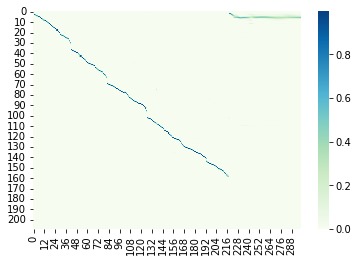


Epoch: 2/5


Train:   0%|          | 0/446 [00:00<?, ?it/s]

Val:   0%|          | 0/43 [00:00<?, ?it/s]

Ground Truth :  ['A', 'N', 'D', ' ', 'I', 'N', ' ', 'H', 'I', 'S', ' ', 'S', 'P', 'E', 'E', 'C', 'H', ' ', 'H', 'E', ' ', 'L', 'A', 'U', 'G', 'H', "'", 'D', ' ', 'A', 'N', 'D', ' ', 'L', 'A', 'U', 'G', 'H', "'", 'D', ' ', 'A', 'G', 'A', 'I', 'N', ' ', 'T', 'H', 'E', 'N', ' ', 'W', 'H', 'I', 'L', 'E', ' ', 'I', 'T', ' ', 'W', 'A', 'S', ' ', 'H', 'I', 'S', ' ', 'P', 'L', 'E', 'A', 'S', 'U', 'R', 'E', ' ', 'T', 'O', ' ', 'R', 'E', 'M', 'A', 'I', 'N', ' ', 'I', ' ', 'C', 'H', 'A', 'N', 'C', 'E', 'D', ' ', 'T', 'O', ' ', 'L', 'O', 'O', 'K', ' ', 'T', 'H', 'E', ' ', 'W', 'A', 'Y', ' ', 'H', 'E', ' ', 'H', 'A', 'D', ' ', 'D', 'R', 'A', 'W', 'N', ' ', 'N', 'E', 'A', 'R', ' ', 'A', 'N', 'D', ' ', 'S', 'A', 'W', ' ', 'T', 'H', 'E', ' ', 'L', 'A', 'D', 'I', 'E', 'S', ' ', 'J', 'O', 'A', 'N', ' ', 'A', 'N', 'D', ' ', 'B', 'E', 'A', 'T', 'R', 'I', 'C', 'E', ' ', 'A', 'P', 'P', 'R', 'O', 'A', 'C', 'H', ' ', 'M', 'E', ' ', 'T', 'H', 'I', 'S', ' ', 'T', 'H', 'E', ' ', 'O', 'T', 'H', 'E', 'R', ' ', 'F'

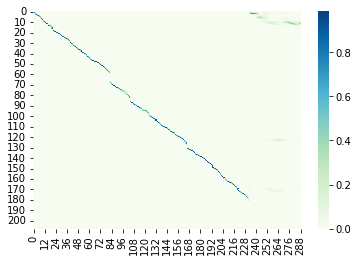

Saving model

Epoch: 3/5


Train:   0%|          | 0/446 [00:00<?, ?it/s]

Val:   0%|          | 0/43 [00:00<?, ?it/s]

Ground Truth :  ['A', ' ', 'S', 'E', 'C', 'O', 'N', 'D', ' ', 'C', 'O', 'U', 'S', 'I', 'N', ' ', 'O', 'F', ' ', 'M', 'A', 'R', 'Y', ' ', 'A', 'N', 'N', "'", 'S', ' ', 'I', 'S', ' ', 'I', 'N', ' ', 'T', 'H', 'E', ' ', 'C', 'O', 'O', 'K', "'", 'S', ' ', 'T', 'O', 'U', 'R', 'S', ' ', 'L', 'I', 'N', 'E']
Prediction   :  ['A', ' ', 'S', 'E', 'C', 'O', 'N', 'D', ' ', 'C', 'O', 'U', 'S', 'I', 'N', ' ', 'O', 'F', ' ', 'M', 'A', 'R', 'I', 'A', 'N', 'N', 'E', 'S', ' ', 'I', 'S', ' ', 'I', 'N', ' ', 'T', 'H', 'E', ' ', 'C', 'O', 'O', 'K', "'", 'S', ' ', 'T', 'O', 'O', 'L', ' ', 'O', 'F', ' ', 'T', 'H', 'E', 'M']
Running Loss 0.0388	 Running Perplexity 1.0395
Val Dist 18.2124


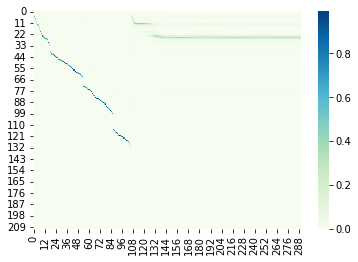


Epoch: 4/5


Train:   0%|          | 0/446 [00:00<?, ?it/s]

Val:   0%|          | 0/43 [00:00<?, ?it/s]

Ground Truth :  ['G', 'R', 'A', 'N', 'T', ' ', 'W', 'A', 'S', ' ', 'O', 'N', 'L', 'Y', ' ', 'A', ' ', 'F', 'E', 'W', ' ', 'M', 'I', 'L', 'E', 'S', ' ', 'A', 'W', 'A', 'Y', ' ', 'B', 'U', 'T', ' ', 'A', 'L', 'T', 'H', 'O', 'U', 'G', 'H', ' ', 'C', 'O', 'M', 'M', 'A', 'N', 'D', 'E', 'R', ' ', 'I', 'N', ' ', 'C', 'H', 'I', 'E', 'F', ' ', 'H', 'E', ' ', 'K', 'N', 'E', 'W', ' ', 'N', 'O', 'T', 'H', 'I', 'N', 'G', ' ', 'O', 'F', ' ', 'T', 'H', 'E', ' ', 'H', 'A', 'R', 'D', 'E', 'S', 'T', ' ', 'F', 'O', 'U', 'G', 'H', 'T', ' ', 'B', 'A', 'T', 'T', 'L', 'E', ' ', 'O', 'F', ' ', 'T', 'H', 'E', ' ', 'C', 'I', 'V', 'I', 'L', ' ', 'W', 'A', 'R', ' ', 'U', 'N', 'T', 'I', 'L', ' ', 'I', 'T', ' ', 'W', 'A', 'S', ' ', 'O', 'V', 'E', 'R']
Prediction   :  ['G', 'R', 'A', 'N', 'T', ' ', 'W', 'A', 'S', ' ', 'O', 'N', 'L', 'Y', ' ', 'A', ' ', 'F', 'E', 'W', ' ', 'M', 'I', 'L', 'E', 'S', ' ', 'A', 'W', 'A', 'Y', ' ', 'B', 'U', 'T', ' ', 'A', 'L', 'T', 'H', 'O', 'U', 'G', 'H', ' ', 'T', 'H', 'E', ' ', 'C', '

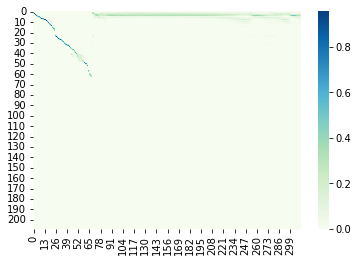


Epoch: 5/5


Train:   0%|          | 0/446 [00:00<?, ?it/s]

Val:   0%|          | 0/43 [00:00<?, ?it/s]

Ground Truth :  ['S', 'T', 'R', 'A', 'I', 'N', ' ', 'A', 'N', 'D', ' ', 'B', 'O', 'T', 'T', 'L', 'E', ' ', 'A', 'N', 'D', ' ', 'P', 'U', 'T', ' ', 'I', 'N', ' ', 'I', 'C', 'E', ' ', 'B', 'O', 'X', ' ', 'S', 'H', 'A', 'K', 'E', ' ', 'B', 'E', 'F', 'O', 'R', 'E', ' ', 'U', 'S', 'I', 'N', 'G', ' ', 'E', 'A', 'C', 'H', ' ', 'T', 'I', 'M', 'E']
Prediction   :  ['S', 'T', 'R', 'A', 'I', 'N', ' ', 'A', 'N', 'D', ' ', 'B', 'O', 'T', 'T', 'L', 'E', ' ', 'A', 'N', 'D', ' ', 'P', 'U', 'T', ' ', 'I', 'N', ' ', 'E', 'Y', 'E', 'S', 'B', 'O', 'X', ' ', 'C', 'H', 'E', 'Q', 'U', 'E', ' ', 'B', 'U', 'T', ' ', 'W', 'E', 'R', 'E', ' ', 'U', 'S', 'I', 'N', 'G', ' ', 'E', 'A', 'C', 'H', ' ', 'T', 'I', 'M', 'E']
Running Loss 0.0390	 Running Perplexity 1.0398
Val Dist 17.2063


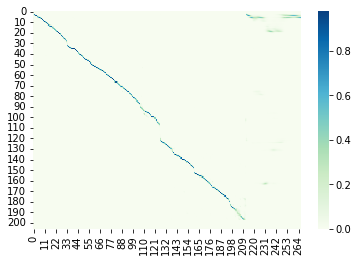

In [ ]:
#tf_rate = 1.0
for epoch in range(0, 5):
    
    print("\nEpoch: {}/{}".format(epoch+1, 5))

    # Call train and validate 
    running_loss, running_perplexity, attention_plot = train(model, train_loader, criterion, optimizer, tf_rate)

    val_dist = validate(model, val_loader)

    scheduler.step(val_dist)

    # Print your metrics
    print("Running Loss {:.04f}\t Running Perplexity {:.04f}".format(running_loss, running_perplexity))
    print("Val Dist {:.04f}".format(val_dist))

    # Plot Attention 
    plot_attention(attention_plot)

    # Log metrics to Wandb

    # Optional: Scheduler Step / Teacher Force Schedule Step
    if (epoch>0)and((epoch+1)%2==0)and(tf_rate>0.4):
      tf_rate -=0.025


    if val_dist <= best_lev_dist:
        best_lev_dist = val_dist
        print("Saving model")
        # torch.save({'model_state_dict':model.state_dict(),
        #             'optimizer_state_dict':optimizer.state_dict(),
        #             'val_dist': val_dist, 
        #             'epoch': epoch}, '/content/drive/MyDrive/HW4checkpoint.pth')
        best_val_dist = val_dist
        # Save your model checkpoint here

In [ ]:
#tf_rate = 1.0
for epoch in range(0, 15):
    
    print("\nEpoch: {}/{}".format(epoch+1, 15))

    # Call train and validate 
    running_loss, running_perplexity, attention_plot = train(model, train_loader, criterion, optimizer, tf_rate)

    val_dist = validate(model, val_loader)

    scheduler.step(val_dist)

    # Print your metrics
    print("Running Loss {:.04f}\t Running Perplexity {:.04f}".format(running_loss, running_perplexity))
    print("Val Dist {:.04f}".format(val_dist))

    # Plot Attention 
    plot_attention(attention_plot)

    # Log metrics to Wandb

    # Optional: Scheduler Step / Teacher Force Schedule Step


    if val_dist <= best_lev_dist:
        best_lev_dist = val_dist
        print("Saving model")
        # torch.save({'model_state_dict':model.state_dict(),
        #             'optimizer_state_dict':optimizer.state_dict(),
        #             'val_dist': val_dist, 
        #             'epoch': epoch}, '/content/drive/MyDrive/HW4checkpoint.pth')
        best_val_dist = val_dist
        # Save your model checkpoint here

In [173]:
for data in test_loader:
    x, lx = data
    print(x.shape, lx.shape)
    break 

torch.Size([64, 825, 15]) torch.Size([64])


In [ ]:
!pip install python-Levenshtein
!git clone --recursive https://github.com/parlance/ctcdecode.git
!pip install wget
%cd ctcdecode
!pip install .
%cd ..

In [ ]:
from ctcdecode import CTCBeamDecoder

In [ ]:
preds = []
stoi = VOCAB_MAP
itos = {value: key for key,value in VOCAB_MAP.items()}
decoder_test = CTCBeamDecoder(list(stoi.keys()), beam_width=10, log_probs_input=True,num_processes=10)

In [ ]:
def indices_to_chars_test(indices):
    tokens = []
    for i in indices: # This loops through all the indices
        if int(i)== SOS_TOKEN: # If SOS is encountered, dont add it to the final list
            continue
        elif int(i) == EOS_TOKEN: # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(i)
    return tokens

def test(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    running_lev_dist = 0.0
    debug_ind = np.random.randint(0,len(dataloader))
    for i, (x, lx) in enumerate(dataloader):
        print(i)

        x, lx = x.to(DEVICE), lx

        with torch.inference_mode():
            predictions, attentions = model(x, lx, y = None)

        beam_results, beam_scores, timesteps, out_seq_len = decoder_test.decode(predictions,seq_lens=lx)

        for i in range(len(beam_results)):
            h_sliced = list(beam_results[i,0][:out_seq_len[i,0]].cpu().numpy())
            h_sliced = indices_to_chars_test(h_sliced)

            h_string = ''.join([itos[c.item()] for c in h_sliced])
            
            preds.append(h_string)

        #print(len(h_string))
        #print(len(preds))
    return preds

In [174]:
# preds = []

In [175]:
# def test(model, dataloader):

#     model.eval()

#     batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

#     running_lev_dist = 0.0

#     predictions = []

#     for i, (x, lx) in enumerate(dataloader):
#         print(i)
#         x, lx = x.to(DEVICE), lx

#         with torch.inference_mode():
#             predictions, attentions = model(x, lx, y = None)


#         # Greedy Decoding
#         greedy_predictions   = torch.argmax(predictions, dim = 2)# How do you get the most likely character from each distribution in the batch?
#         print(greedy_predictions.shape)
#         preds.append(greedy_predictions)
#         print(len(preds))
#         batch_bar.update()

#         del x, lx
#         torch.cuda.empty_cache()

#     batch_bar.close()

#     return preds

In [172]:
#TODO:
# Write a function (predict) to generate predictions and submit the file to Kaggle

torch.cuda.empty_cache()
predictions = test(model, test_loader)
print(len(predictions))
import pandas as pd

df = pd.read_csv('/content/data/hw4p2/test-clean/transcript/random_submission.csv')
df.label = predictions
df = df.rename(columns={'index':'id'})

df.to_csv('submission.csv', index = False)
!kaggle competitions submit -c 11-785-f22-hw4p2 -f submission.csv -m "I made it!"

Val:   0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


2620
100% 285k/285k [00:02<00:00, 128kB/s]
Successfully submitted to Attention-Based Speech Recognition